In [1]:
import json
import os
import cv2 
import matplotlib.pyplot as plt

## First Image Example

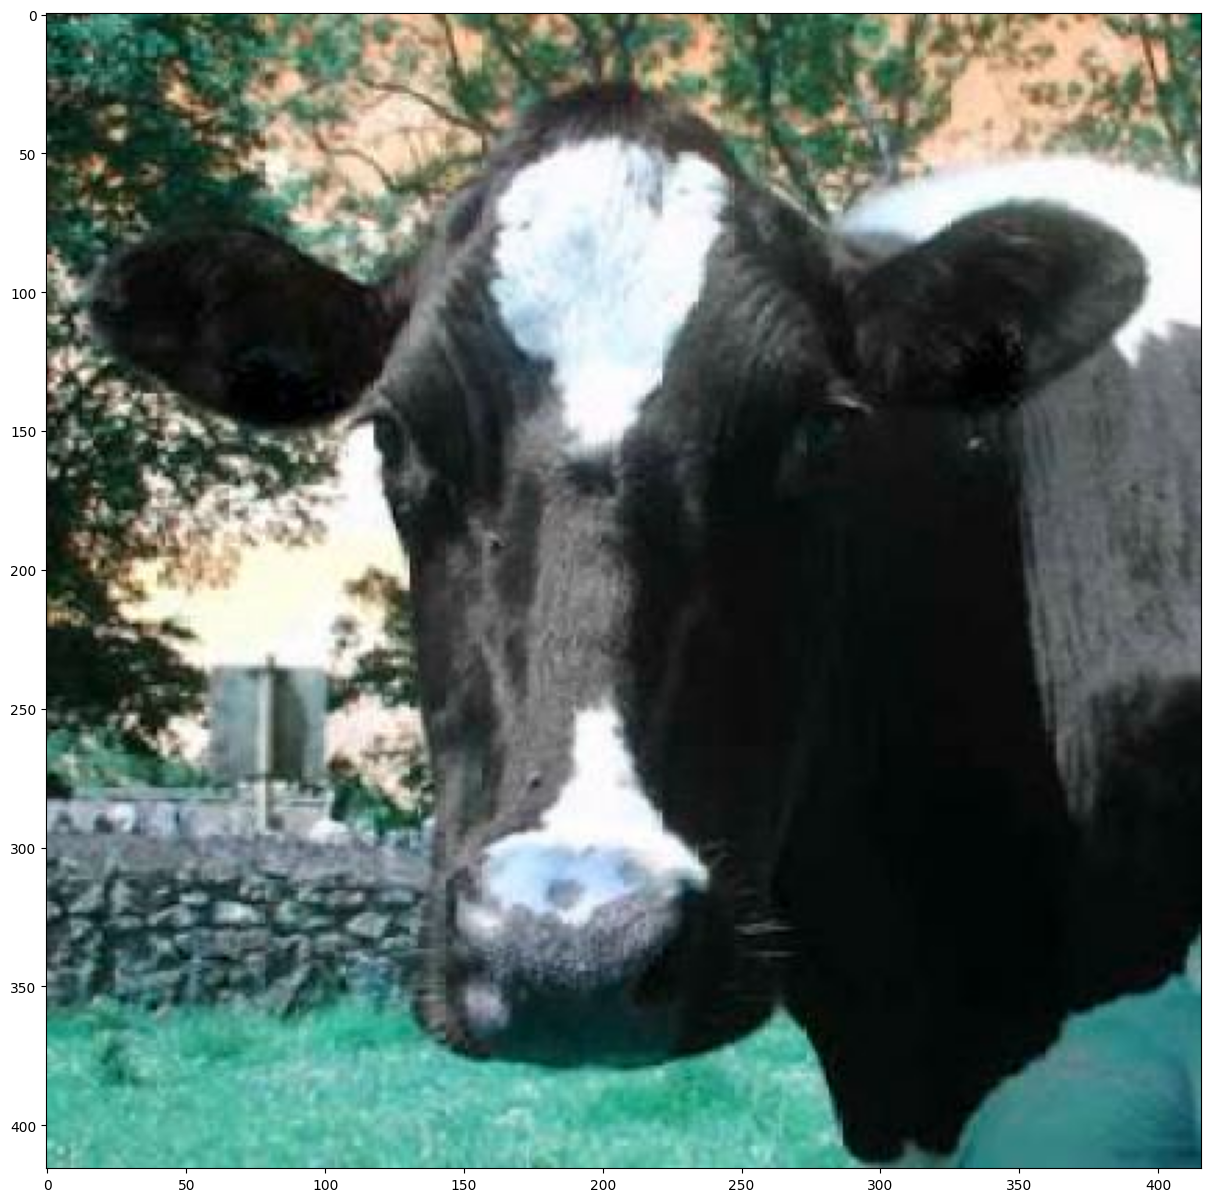

In [14]:
imgexpath = './train/images/0f222e0f-8164-404c-84b6-ea6f577ba32c_jpg.rf.73c4e40c9835767682e947b452e8cb72.jpg'

imgex = cv2.imread(imgexpath)
#img=cv2.cvtColor(img,cv2)

plt.figure(figsize=(15,15))
plt.imshow(imgex)

## First Image Example with Unconverted Labels

In [15]:
imgexlabelpath='./train/labels/0f222e0f-8164-404c-84b6-ea6f577ba32c_jpg.rf.73c4e40c9835767682e947b452e8cb72.txt'

with open(imgexlabelpath) as f:
    lines_txt = f.readlines() 
    lines=[]
    for line in lines_txt:
        lines.append([int(line.split()[0])]+[round(float(el),7) for el in line.split()[1:]])
        print(lines[-1]) 


[1, 0.4831731, 0.8233173, 0.3016827, 0.1838942]
[2, 0.4651442, 0.8028846, 0.0661058, 0.0360577]


In [16]:
classes = ['lower','upper']
rectangle2keypoints ={0:0,2:1}

In [17]:
def converter(file_labels,file_image,keypoint_names):
    img = cv2.imread(file_image)
    img_w,img_h = img.shape[1],img.shape[0] 
    
    with open(file_labels) as f:
        lines_text = f.readlines() 
        lines=[] 
        for line in lines_text:
            lines.append([int(line.split()[0])]+[round(float(el),7) for el in line.split()[1:]]) 
        
    bboxes=[] 
    keypoints=[] 
    
    for line in lines: 
        if line[0]==1:
            x_c,y_c,w,h = map(round,[line[i]*img_h for i in range(1,5) if i%2==0]+[line[i]*img_h for i in range(1,5) if i%2==1]) 
            bboxes.append(list(map(round,[x_c-w/2,y_c-h/2,x_c+w/2,y_c+h/2]))) 
        
        if line[0]==0 or line[0]==2:
            kp_id,x_c,y_c = rectangle2keypoints[line[0]], round(line[1]*img_h), round(line[2]*img_w)
            print(kp_id,x_c,y_c)
            keypoints.append([kp_id,x_c,y_c]) 
            
    keypoints_sorted = [[[] for _ in keypoint_names] for _ in bboxes] 
    for kp in keypoints:
        kp_id,kp_x,kp_y = kp[0],kp[1],kp[2]
        for bbox_idx,bbox in enumerate(bboxes): 
            x1,y1,x2,y2 = bbox[0],bbox[1],bbox[2],bbox[3] 
            if x1<kp_x<x2 and y1<kp_y<y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x,kp_y,1] 
    return bboxes,keypoints_sorted

In [18]:
def converter1(file_labels, file_image, keypoint_names):

    img = cv2.imread(file_image)
    img_w, img_h = img.shape[1], img.shape[0]
    
    with open(file_labels) as f:
        lines_txt = f.readlines()
        lines = []
        for line in lines_txt:
            lines.append([int(line.split()[0])] + [round(float(el), 5) for el in line.split()[1:]])

    bboxes = []
    keypoints = []

    # In this loop we convert normalized coordinates to absolute coordinates
    for line in lines:
        # Number 0 is a class of rectangles related to bounding boxes.
        if line[0] == 1:
            x_c, y_c, w, h = round(line[1] * img_w), round(line[2] * img_h), round(line[3] * img_w), round(line[4] * img_h)
            bboxes.append([round(x_c - w/2), round(y_c - h/2), round(x_c + w/2), round(y_c + h/2)])

        # Other numbers are the classes of rectangles related to keypoints.
        # After convertion, numbers of keypoint classes should start with 0, so we apply rectangles2keypoints dictionary to achieve that.
        # In our case:
        # 1 is rectangle for head keypoint, which is 0, so we convert 1 to 0;
        # 2 is rectangle for tail keypoint, which is 1, so we convert 2 to 1.
        if line[0] != 1:
            kp_id, x_c, y_c = rectangle2keypoints[line[0]], round(line[1] * img_w), round(line[2] * img_h)
            keypoints.append([kp_id, x_c, y_c])

    # In this loop we are iterating over each keypoint and looking to which bounding box it matches.
    # Thus, we are matching keypoints and corresponding bounding boxes.
    keypoints_sorted = [[[0,0,0],[0,0,0]] for _ in bboxes]
    for kp in keypoints:
        kp_id, kp_x, kp_y = kp[0], kp[1], kp[2]
        for bbox_idx, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox[0], bbox[1], bbox[2], bbox[3]
            if x1 < kp_x < x2 and y1 < kp_y < y2:
                keypoints_sorted[bbox_idx][kp_id] = [kp_x, kp_y, 1] # All keypoints are visible
                
    return bboxes, keypoints_sorted


In [19]:
bboxes,keypoints_sorted=converter1(imgexlabelpath,imgexpath,classes) 
print(bboxes)
print(keypoints_sorted)

[[138, 305, 264, 381]]
[[[0, 0, 0], [193, 334, 1]]]


In [8]:
def dump2json(bboxes, keypoints_sorted, file_json):
    annotations = {}
    annotations['bboxes'], annotations['keypoints'] = bboxes, keypoints_sorted
    with open(file_json, "w") as f:
        json.dump(annotations, f)

In [22]:
IMAGES = './valid/images'
LABELS = './valid/labels'
ANNOTATIONS = './valid/annotations'

files_names = [file.split('.jpg')[0] for file in os.listdir(IMAGES)]

for file in files_names:
    file_labels = os.path.join(LABELS, file + ".txt")
    file_image = os.path.join(IMAGES, file + ".jpg")
    bboxes, keypoints_sorted = converter1(file_labels, file_image, classes)
    dump2json(bboxes, keypoints_sorted, os.path.join(ANNOTATIONS, file + '.json'))